In [226]:
import os

import rasterio
import osmnx as ox

import pandas as pd
import geopandas as gpd

import positron as pt

from shapely.geometry import box
from shapely.geometry import Polygon, LineString, MultiLineString

pd.set_option('display.max_columns', None)

In [227]:
import warnings
warnings.filterwarnings('ignore')

## 1. Building & Park Extraction

In [ ]:
grid = gpd.read_file('../data/yerevan_grid.geojson')

In [77]:
place_name = "Yerevan, Armenia"

buildings = ox.geometries_from_place(
    place_name,
    tags={'building': True}
)

parks = ox.geometries_from_place(
    place_name, 
    tags={"leisure": ["park", "garden", "recreation_ground", "amusement_park"]}
)

buildings = buildings.to_crs(epsg=4326)
buildings.reset_index(inplace=True)

parks = parks.to_crs(epsg=4326)
parks.reset_index(inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6148\3478568444.py:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings = ox.geometries_from_place(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6148\3478568444.py:8: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  parks = ox.geometries_from_place(


In [ ]:
buildings = buildings.sjoin(grid[['geometry']], predicate='intersects')

buildings = buildings[[
    'osmid', 'name', 'name:en', 'building',
    'addr:country', 'addr:city', 'addr:district', 'addr:region', 'addr:housenumber', 'addr:postcode', 'addr:street', 
    'check_date', 'geometry'
]]

buildings.drop_duplicates(inplace=True)

In [79]:
parks = parks.sjoin(grid[['geometry']], predicate='intersects')

parks = parks[[
    'osmid', 'name', 'name:en', 'old_name', 'leisure',
    'addr:country', 'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street',
    'check_date', 'geometry'
]]

parks.drop_duplicates(inplace=True)

In [ ]:
buildings.to_file("../data/yerevan_buildings.geojson", driver="GeoJSON")
parks.to_file("../data/yerevan_parks.geojson", driver="GeoJSON")

## 2. Adding the Image ID to Buildings

In [ ]:
buildings = gpd.read_file("../data/yerevan_buildings.geojson")

In [89]:
def assign_img_id_to_buildings_from_images(image_folder, buildings_gdf):
    """
    Reads all georeferenced .tif images in a folder, finds buildings that intersect with each image,
    and assigns the image index (img_id) from the filename to those buildings.

    Parameters:
    - image_folder: str, path to folder containing .tif files named like {index}.tif
    - buildings_gdf: GeoDataFrame with building geometries in EPSG:4326

    Returns:
    - GeoDataFrame of buildings with an added 'img_id' column
    """
    assigned_buildings = []

    for filename in os.listdir(image_folder):
        if filename.endswith(".tif"):
            tile_index = int(os.path.splitext(filename)[0])
            img_path = os.path.join(image_folder, filename)

            with rasterio.open(img_path) as src:
                bounds = src.bounds
                img_crs = src.crs
                img_geom = box(*bounds)
                img_gdf = gpd.GeoDataFrame({'geometry': [img_geom]}, crs=img_crs)

            # Reproject buildings if needed
            if buildings_gdf.crs != img_crs:
                buildings_proj = buildings_gdf.to_crs(img_crs)
            else:
                buildings_proj = buildings_gdf

            # Select buildings that intersect the image extent
            buildings_in_tile = buildings_proj[buildings_proj.intersects(img_geom)].copy()
            if not buildings_in_tile.empty:
                buildings_in_tile['img_id'] = tile_index
                assigned_buildings.append(buildings_in_tile)

    # Combine all assigned buildings
    combined_gdf = gpd.GeoDataFrame(pd.concat(assigned_buildings, ignore_index=True), crs=buildings_gdf.crs)

    return combined_gdf

In [90]:
image_folder = "georeferenced_images"
buildings = assign_img_id_to_buildings_from_images(image_folder, buildings)

In [ ]:
buildings.to_file("../data/yerevan_buildings.geojson", driver="GeoJSON")

## 3. Cleaning Buildings

In [ ]:
buildings = gpd.read_file("../data/yerevan_buildings.geojson")

In [93]:
buildings.columns

Index(['osmid', 'name', 'name:en', 'building', 'addr:country', 'addr:city',
       'addr:district', 'addr:region', 'addr:housenumber', 'addr:postcode',
       'addr:street', 'check_date', 'amenity', 'shop', 'img_id', 'geometry'],
      dtype='object')

In [94]:
buildings = buildings[buildings['building'].isin(['yes', 'apartments', 'house'])]

buildings = buildings[buildings['amenity'].isna()]
buildings = buildings[buildings['shop'].isna()]

In [ ]:
buildings.to_file('../data/yerevan_buildings_clean.geojson', driver='GeoJSON')

## 4. Extracting Districts

In [ ]:
yerevan = gpd.read_file('../data/yerevan_boundary/yerevan.shp')

In [214]:
yerevan = yerevan.unary_union
yerevan = gpd.GeoDataFrame(geometry=[yerevan], crs='EPSG:4326')

In [215]:
yerevan = pt.apply_buffer(yerevan, buffer=50, geom_col='geometry', drop_geometry=True)

yerevan.rename(columns={'geometry_buffered':'geometry'}, inplace=True)
yerevan.set_geometry('geometry', inplace=True)

<Axes: >

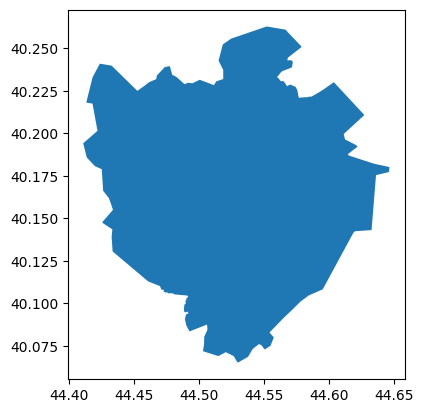

In [216]:
yerevan.plot()

In [217]:
districts = ox.geometries_from_polygon(
    yerevan['geometry'][0],
    tags={"admin_level": "8", "boundary": "administrative"}
)

districts.reset_index(inplace=True)
districts = districts[['name', 'geometry']]

In [ ]:
districts = districts[districts['name'].isin([
    'Նուբարաշեն', 'Շենգավիթ', 'Էրեբունի', 'Նորք Մարաշ', 'Կենտրոն',
    'Մալաթիա-Սեբաստիա', 'Նոր Նորք', 'Ավան', 'Քանաքեռ-Զեյթուն',
    'Աջափնյակ', 'Դավթաշեն', 'Արաբկիր'
])]

districts['name'] = [
    'Nubarashen', 'Shengavit', 'Erebuni', 'Norq Marash', 'Kentron',
    'Malatia-Sebastia', 'Nor Norq', 'Avan', 'Qanaqer-Zeytun',
    'Arabkir', 'Davtashen', 'Ajapnyak'
]

districts.reset_index(drop=True, inplace=True)

In [233]:
districts

,name,geometry
0,Nubarashen,"POLYGON ((44.50691 40.08680, 44.50906 40.08661..."
1,Shengavit,"POLYGON ((44.42506 40.13095, 44.42834 40.13088..."
2,Erebuni,"POLYGON ((44.50819 40.16315, 44.50926 40.16314..."
3,Norq Marash,"POLYGON ((44.52546 40.16819, 44.52557 40.16826..."
4,Kentron,"POLYGON ((44.47919 40.18724, 44.47949 40.18728..."
5,Malatia-Sebastia,"MULTIPOLYGON (((44.36211 40.14670, 44.36211 40..."
6,Nor Norq,"POLYGON ((44.54182 40.16598, 44.54173 40.16624..."
7,Avan,"POLYGON ((44.55966 40.23611, 44.56422 40.23812..."
8,Qanaqer-Zeytun,"POLYGON ((44.51651 40.19559, 44.51664 40.19577..."
9,Arabkir,"POLYGON ((44.48259 40.19145, 44.48191 40.19234..."


In [ ]:
districts.to_file('../data/yerevan_districts.geojson')